Libraries

In [8]:
import torch, torch.nn as nn, torch.optim as optim, pandas as pd, matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp
from sklearn.model_selection import train_test_split
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

Functions

In [18]:
def load_datasets(dataset):
    df1 = pd.read_csv(f'data/class1_data_{dataset}.dat', delimiter='\t')
    df1.columns = ['feature_1', 'feature_2']
    df2 = pd.read_csv(f'data/class2_data_{dataset}.dat', delimiter='\t')
    df2.columns = ['feature_1', 'feature_2']
    df1['label'] = 0
    df2['label'] = 1

    df = pd.concat([df1, df2], ignore_index=True)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    data = torch.tensor(df.values, dtype=torch.float32)
    x = data[:, :-1]
    y = data[:, -1].unsqueeze(1)
    return x, y

def entangling_block(qc, thetas, start_index=0):
    qc.rz(thetas[start_index], 0)
    qc.cry(thetas[start_index+1], 0, 1)
    qc.rz(thetas[start_index+2], 1)
    qc.cry(thetas[start_index+3], 1, 0)


def full_qnn_circuit(num_qubits, depth, thetas, x=None):
    qc = QuantumCircuit(num_qubits)
    if x is None:
        x0, x1 = Parameter("x0"), Parameter("x1")
    else:
        x0, x1 = x[0], x[1]
    
    for _ in range(3):
        # Encoding layer
        qc.h(range(num_qubits))
        qc.rx(x0, 0)
        qc.ry(x1, 1)
        # Variational entanglement layer
        for d in range(depth):
            entangling_block(qc, thetas, d * 4)
    
    
    return qc

def normalize(x: torch.Tensor) -> torch.Tensor:
    mean = x.mean(dim=0, keepdim=True)
    std = x.std(dim=0, keepdim=True) + 1e-8  # to prevent division by 0
    return (x - mean) / std

Data loading & Parameter initialization

In [19]:
x_train, y_train = load_datasets('train')
x_test, y_test = load_datasets('test')

x_train = normalize(x_train)
x_test = normalize(x_test)

# Split training set into train and validation
x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

# Hyperparameters
num_qubits = 2
epochs = 30
depth = 1 # depth of the variational layer
patience = 5 # for early stopping

# Quantum Parameters
thetas = [Parameter(f"θ{i}") for i in range(4 * depth)]

# Observables
obs = SparsePauliOp.from_list([
    ("ZI", 1.0),   # Z on qubit 0
    ("IZ", 1.0),   # Z on qubit 1
    ("ZZ", 1.0),   # Z-axis entanglement
    ("XX", 1.0),   # X-axis entanglement
    ("YY", 1.0),   # Y-axis entanglement
])


Instantiate model, loss, optimizer

In [20]:
qnn = EstimatorQNN(
    circuit=full_qnn_circuit(num_qubits, depth, thetas),
    input_params=[Parameter("x0"), Parameter("x1")],
    weight_params=thetas,
    observables=obs
)

qnn_torch = TorchConnector(qnn)

class VQCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.qnn = qnn_torch

    def forward(self, x):
        x = self.qnn(x)
        return x
    
model = VQCModel()
criterion = nn.BCEWithLogitsLoss()
base_lr = 1e-1
optimizer = optim.Adam(model.parameters(), lr=base_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.25)

Trainning

In [12]:
best_f1_val = 0
losses = []
val_losses = []
no_improvement_counter = 0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train_split)
    loss = criterion(outputs, y_train_split)
    loss.backward()
    optimizer.step()
    scheduler.step()
    y_pred_train = (outputs >= 0.5).int().squeeze()
    f1_train = f1_score(y_train_split.numpy().astype(int), y_pred_train)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())

        y_val_pred = (val_outputs >= 0.5).int().squeeze()
        f1_val = f1_score(y_val.numpy().astype(int), y_val_pred)

    losses.append(loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, F1_train: {f1_train:.4f}, F1_val: {f1_val:.4f}")

    # Early stopping
    if (f1_val - 0.001) < best_f1_val: # improvement: f1 score for the validation set improves more than 0.001
        no_improvement_counter += 1
        if no_improvement_counter == patience:
            print(f"Early stopping: No improvement on f1 score for the validation set for {patience} consecutive epochs.")
            break
    else:
        best_f1_val = f1_val
        no_improvement_counter = 0

Epoch 1/30, Train Loss: 0.4597, Val Loss: 0.6608, F1_train: 0.8049, F1_val: 0.6471
Epoch 2/30, Train Loss: 0.4302, Val Loss: 0.5967, F1_train: 0.8025, F1_val: 0.6207
Epoch 3/30, Train Loss: 0.4051, Val Loss: 0.5526, F1_train: 0.7947, F1_val: 0.6667
Epoch 4/30, Train Loss: 0.3874, Val Loss: 0.5262, F1_train: 0.8387, F1_val: 0.6897
Epoch 5/30, Train Loss: 0.3732, Val Loss: 0.5079, F1_train: 0.8679, F1_val: 0.6897
Epoch 6/30, Train Loss: 0.3609, Val Loss: 0.5046, F1_train: 0.9091, F1_val: 0.7333
Epoch 7/30, Train Loss: 0.3582, Val Loss: 0.5022, F1_train: 0.9091, F1_val: 0.7333
Epoch 8/30, Train Loss: 0.3556, Val Loss: 0.5006, F1_train: 0.9036, F1_val: 0.7333
Epoch 9/30, Train Loss: 0.3532, Val Loss: 0.4996, F1_train: 0.9036, F1_val: 0.7333
Epoch 10/30, Train Loss: 0.3511, Val Loss: 0.4993, F1_train: 0.8982, F1_val: 0.7097
Epoch 11/30, Train Loss: 0.3494, Val Loss: 0.4993, F1_train: 0.8982, F1_val: 0.7097
Early stopping: No improvement on f1 score for the validation set for 5 consecutive e

Validation

              precision    recall  f1-score   support

           0       0.94      0.84      0.89        19
           1       0.86      0.95      0.90        19

    accuracy                           0.89        38
   macro avg       0.90      0.89      0.89        38
weighted avg       0.90      0.89      0.89        38



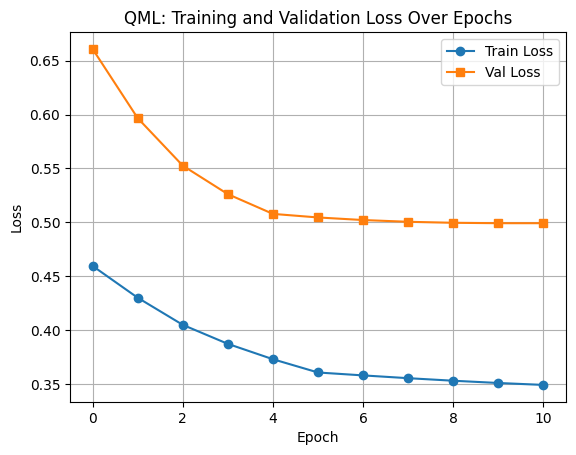

In [13]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(x_test)
    y_pred_labels = (y_pred_probs >= 0.5).int().squeeze()

y_true = y_test.numpy().astype(int)
y_pred = y_pred_labels.numpy()

print(classification_report(y_true, y_pred))

plt.plot(losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='s')
plt.title("QML: Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Confusion Matrix

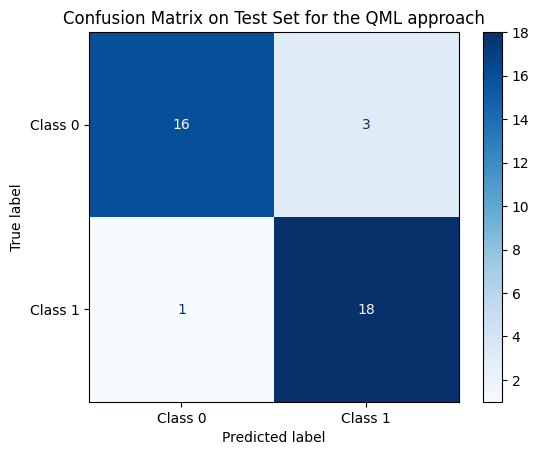

In [14]:
cm = confusion_matrix(y_test.numpy().astype(int), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set for the QML approach")
plt.grid(False)
plt.show()
